# Project Milestone 2
> CS-401 - Applied Data Analysis

> *Group Padawan - Fall 2024*

>*Maxime Ducourau*, *Mehdi Zoghlami*, *Léopold Henry*, *Martin Catheland*, *Jean Perbet*

This notebook is an exploratory analysis of the [YouNiverse](https://zenodo.org/records/4650046) dataset, which contains data about **137k** english-speaking [YouTube](https://youtube.com) channels having more than **10k** subscribers, and their **73M** videos, uploaded between **2005** and **2019**. 

We chose to focus on the **gaming** category, which is one of the most popular on YouTube. We will try to adress the following **research questions**:
- What are the most popular games on YouTube ?
- Is there a link between real-world gaming events and releases, and the popularity of games on YouTube ?
- What are the most linked communities in the gaming category ?

Due to the considerable size of the dataset, we pre-filtered the original dataset to only keep the **gaming videos**, their **comments**, the **channels** that have uploaded at least one video in the gaming category and their **time-series**. We also took advantage of it to remove some useless / heavy-weight fields.

This pre-filtering is available in the notebook `prefiltering.ipynb`. Below is a summary of the datasets at our disposal, after pre-filtering.

| File | Description | Fields |
| --- | --- | -- |
| `gaming_videos.tsv` | Videos | `title`, `tags`, `upload_date`, `view_count`, `like_count`, `dislike_count`, `duration`, `channel_id`, `display_id` |
| `gaming_comments.tsv` | Comments | `author`, `video_id`|
| `gaming_channels.tsv` | Channels | `channel_id`, `channel_name`, `subscribers` |
| `gaming_timeseries.tsv` | Channels time-series | `channel_id`, `datetime`, `views`, `delta_views`, `subs`, `delta_subs`, `videos`, `delta_videos` |

We'll first examine the datasets to understand our data, its distribution and its stastistical properties, and then we'll perform some initial opersations to try to answer our previously mentioned research questions. Let's first load the libraries and create the constants we will need later.

It is important to notice that we will use the [`polars`](https://pola.rs) library for large datasets (i.e. for videos metadata and comments) throughout this notebook, which is a blazingly fast data frame library allowing lazy evaluation and parallel processing. For cells which take a long time to run, we provide the expected time to run the cell as a comment.

In [ ]:
# data frames
import pandas as pd
import polars as pl

# math
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import string

# progress tracking
from tqdm import tqdm
tqdm.pandas()

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# youniverse paths
VIDEOS_PATH = "../data/youniverse/filtered/gaming_videos.tsv"
CHANNELS_PATH =  "../data/youniverse/filtered/gaming_channels.tsv"
TIMESERIES_PATH = "../data/youniverse/filtered/gaming_timeseries.tsv"
COMMENTS_PATH =  "../data/youniverse/filtered/gaming_comments.tsv"

# additional paths
GAMES_PATH = "../data/games.csv"
ESPORTS_PATH = "../data/esports_tournaments.csv"
WORDS_PATH = "../data/words_alpha.txt"

# random seed
RANDOM_STATE = 1

### Channel metadata

Let's first explore the **channels metadata**, and get some statistics.

In [ ]:
channels_df = pd.read_csv(CHANNELS_PATH, sep='\t')

We quickly check the number of missing values in order to drop them if possible.

In [ ]:
channels_df.isna().sum()

As we can see, the number of missing values is pretty negligible, so we can drop them.

In [ ]:
channels_df = channels_df.dropna()

In [ ]:
channels_df.describe()

Here is some important information to notice. 
- The **mean number of subscribers** is **~250k**, whereas the **standard deviation** is more than **1M** : this indicates highly varying data, with extreme outliers: this is expected looking at the **minimum** and **maximum** values, which are **10k** and **112M** respectively.
- The same applies to the **number of videos** uploaded by the channels, with a **mean** of **~700** and a **standard deviation** of **~4.5k**.

Now, let's plot the distribution of the number of subscribers per channel. 




In [ ]:
plt.hist(channels_df['subscribers'], bins=100, range=(0, channels_df['subscribers'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Number of subscribers')
plt.ylabel('Number of channels')
plt.title('Distribution of number of subscribers');

Unsurprsingly, the distribution is **right-skewed**, with a **long tail** of channels having a very high number of subscribers.

Let's bin channels depending on their popularity : different **subscriber bins** often **represent different stages** of a channel's development and **reduces variability** within each segment, which can make trends more **statistically significant** and **clearer** to interpret.

The ranges will be as follows.
- $10000$ - $100000$: **Small** channels, mostly posting videos as a hobby
- $100000$ - $1000000$: **Medium** size channels that start reaching mainstream status.
- $1000000$ or more: **Large** channels that can reach worlwide popularity, they are quite rare

In [ ]:
def segment_channel(df: pd.DataFrame, lower_bound: int, upper_bound: float) -> pd.DataFrame:
    """
    Segments the channels based on the number of subscribers.
    
    Args:
        df: pd.DataFrame - the channels dataframe to segment
        lower_bound: int - the lower bound of the segment
        upper_bound: float - the upper bound of the segment
        
    Returns:
        pd.DataFrame - the segmented dataframe
    """
    return df[(df["subscribers"] >= lower_bound) & (df["subscribers"] < upper_bound)]

sized_channel_dfs = [
    segment_channel(channels_df, 10_000, 100_000),
    segment_channel(channels_df, 100_000, 1_000_000),
    segment_channel(channels_df, 1_000_000, float('inf'))
]

In [ ]:
labels = ["Small", "Medium", "Large"]
plt.pie(
    [len(df) for df in sized_channel_dfs],
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=['#ff9999', '#66b3ff', '#99ff99'] 
);

### Time-series

Now, before going any further, let's examine the **time-series** data. Since we begin to deal with quite a **lot of data**, we'll start to use the `polars` library.

In [29]:
timeseries_df = pl.read_csv(TIMESERIES_PATH, separator='\t')

Here, a quick checks shows that there is not a single missing value.

In [ ]:
timeseries_df.null_count()

Again, let's just check a few statistics.

In [ ]:
timeseries_df.describe()

Here, it makes no sense to study the **mean** and **standard deviation** of the **views**, **subs** and **videos** columns, as they are **cumulative** values. The meaningful insights are the following.
- The **mean weekly delta subscribers** and **views** are **~930** and **~260k** respectively, with huge **standard deviations** also indicating extreme outliers.
- The **mean weekly delta videos** is **~2.8**, which seems to a reasonable value, but looking at the **maximum** tells us that one channel once posted almost **3k** videos in a week !

Now that we have a better understanding of both our channels and timeseries data, let's try to find a correlation between the **number of subscribers** and the **number of views**. We'll divide our analysis between previously determined *small*, *medium* and *large* channels.

 1. Firstly, let's merge the **number of subscribers**  with the **total number of views** for each channel, which is the last value of our timeseries for each channel.

In [ ]:
views_df = (
    timeseries_df
    .group_by('channel_id')
    .agg(pl.col('views').last())
)

In [ ]:
sized_sub_views_dfs = [
    views_df.join(pl.from_pandas(df), on='channel_id', how='inner')
    for df in sized_channel_dfs
]

2. Then we'll leverage the `regplot` function from `seaborn` to plot the **number of subscribers** against the **number of views** for each channel, and color the points depending on the channel's size.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Creates a 1x3 grid of plots
for i, (df, name) in enumerate(zip(sized_sub_views_dfs, ["Small", "Medium", "Large"])):
    sns.regplot(
        data=df,
        x="views",
        y="subscribers",
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "red"},
        ax=axes[i]
    )
    axes[i].set_title(f"{name} gaming channels views vs. subscribers")

In [ ]:
print("Correlation coefficient between views and subscribers for gaming channels:")
for df, name in zip(sized_sub_views_dfs, ["Small", "Medium", "Large"]):
    corr = df.select(pl.corr("views", "subscribers")).item()
    print(f"{name} channels: {corr:.2f}")

We have evidence that the number of views is positively correlated to the number of subscribers. This correlation is weak for small channels, moderate for medium channels and strong for large channels. 

We interpret this as follows. Small channels tend to produce content that people will watch **regardless of their subscriber count**, only because they are interested, whereas medium and large channels tend to have a more loyal audience that will watch **most of their content** due to their **popularity**.

### Video metadata

Let's dive into the **videos metadata**. Since it is quite huge, we'll use `polars` library to load the data.

In [ ]:
# ~30s
videos_df = pl.read_csv(VIDEOS_PATH, separator='\t')

First, let's get some insights about our data, starting with the number of gaming videos we have at our disposal.

In [ ]:
len(videos_df)

We have more than **13.7 million** videos, that's quite a good knowledge base ! Let's get some statistics.

In [ ]:
# ~19s
videos_df.describe()

It's interesting to see that, **on average**, between may 2005 and october 2019, the **~137k** studied english channels have **~76k views** per video, and their videos last **~24 minutes**. The same pattern applies for the **views** as for the channels **subscribers**, which makes sense: there are extreme outliers which add a lot of vairance to the metrics.

Let's try to visualize the distribution of the number of views and the duration of the videos. We'll create a sample of $5\%$ of the data to avoid runtime issues, while still being representative of the whole dataset.

In [ ]:
# ~1min
videos_sample_df = videos_df.sample(fraction=0.05, seed=RANDOM_STATE)
print(f'There are {len(videos_sample_df)} videos in the sample dataset.')

In [ ]:
plt.hist(videos_sample_df['duration'], bins=150, range=(0, videos_sample_df['duration'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Video duration (seconds)')
plt.ylabel('Number of videos')
plt.title('Distribution of Video Duration');

It's very interesting here to notice the peak at **10min**, which at the period captured by thie dataset, corresponded to the minimum duration of a video that allowed content creators to freely decide the number of ads they could insert, maximizing their videos' **monetization**.

In [ ]:
plt.hist(videos_sample_df['view_count'], bins=10, range=(0, videos_sample_df['view_count'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Views')
plt.ylabel('Number of videos')
plt.title('Distribution of Views');

Now, let's visualize the distribution accross time of the **upload date** of our gaming videos.

In [ ]:
# ~4s
upload_dates = (
    videos_sample_df
    .with_columns(
        pl.col("upload_date").str.to_date(format="%Y-%m-%d %H:%M:%S"),
    )
    .with_columns(
        pl.col("upload_date").dt.month_start()
    )
    .get_column("upload_date")
)

monthly_counts = upload_dates.value_counts().sort("upload_date").to_pandas()
monthly_counts.plot(kind='line', x='upload_date', y='count', color='skyblue', legend=False)
plt.xlim(right=pd.Timestamp('2019-08-31'))
plt.xlabel('Upload date')
plt.ylabel('Number of videos')
plt.title('Distribution of Upload Dates')
plt.xticks(rotation=45);


It follows the general trend of YouTube, with **increasing uploads** over time.

#### Most common tags & titles

Now, let's dive deeper into our `title` and `tags` field. We noticed that the `tags` field is a list of tags, where they're separated by a comma. What would be super interesting to do is extracting all different tags and see which ones are the most common. We carry on with our sample of $5\%$ of the data.

In [ ]:
# ~40s
tag_counts = (
    videos_sample_df
    .select('tags')
    .with_columns(pl.col("tags").str.to_lowercase())
    .with_columns(pl.col("tags").str.split(","))
    .explode("tags")
    .group_by("tags")
    .count()
    .sort("count", descending=True)
)
tag_counts.head(15)

Very interesting ! We can already see that `minecraft` is tagged on a huge number of videos.

Let's apply the same methodology to `title` filed, but his time splitting the words by space.

In [ ]:
# ~30s
title_counts = (
    videos_sample_df
    .select('title')
    .with_columns(pl.col("title").str.to_lowercase())
    .with_columns(pl.col("title").str.split(" "))
    .explode("title")
    .group_by("title")
    .count()
    .sort("count", descending=True)
)
title_counts.head(15)

As we can see, this is less representative. We can try to check some famous games in the `tag_counts` to evaluate their interest.

In [ ]:
print(f'Number of tags containing "fifa": {tag_counts.filter(pl.col("tags") == "fifa").select("count").item()}')
print(f'Number of tags containing "minecraft": {tag_counts.filter(pl.col("tags") == "minecraft").select("count").item()}')
print(f'Number of tags containing "league of legends": {tag_counts.filter(pl.col("tags") == "league of legends").select("count").item()}')

## Video games dataset

 Now, we will cross our dataset with another one, containing an almost-comprehensive list of more than **41k** unique commercial video games. It is available [here](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games). So as to keep this study manageable, we will only focus on the first **~1k** most popular games, since we assume they represent the vast majority of YouTube gaming videos.
 
Let's load and filter out the dataset.

In [ ]:
games_df = pd.read_csv(GAMES_PATH, index_col=0).drop_duplicates("Title").reset_index(drop=True)
games_df.head(3)

We'll use the `Plays` feature to estimate the popularity of the games, and we'll use a cutoff of **2k** games to keep.

In [ ]:
cutoff = 2000
games_df["Plays_Numeric"] = games_df["Plays"].apply(lambda x: float(x.replace('k', '').replace('K', '')) * 1000 if "k" in x or "K" in x else float(x))
games_df = games_df.sort_values(by="Plays_Numeric", ascending=False).drop(columns=["Plays_Numeric"])
games_df = games_df.iloc[:cutoff]

Then, we'll remove game names that are too short and those that are common english names, as they are likely to be noise. We pick the list of common english names [here](https://github.com/dwyl/english-words).

In [ ]:
with open(WORDS_PATH, "r") as f:
    words = {line.strip() for line in f}

games_df = games_df[(games_df["Title"].str.len() > 4) & ~(games_df["Title"].str.lower().isin(words))].reset_index(drop=True)

Some video games are just specific versions of other games, see for instance the *Tetris* example.

In [ ]:
games_df[games_df["Title"].str.contains("Tetris")]

Since we're not interested in specific versions but rather in the game itself, we will remove all games that are a superstring of another game.

In [ ]:
games_df = games_df[games_df['Title'].apply(lambda x: not any(other in x for other in games_df['Title'] if x != other))].reset_index(drop=True)

Since the titles and tags are quite noisy and may contain a lot of irrelevant information as well as different names for a given video game (e.g. *LoL* for *League of Legends*, *gta* for *Grand Theft Auto V*, etc.), we searched for a good and effective way to extract the game names from the `title` and `tags` field. 

- We first tried to use **TF-IDF** embeddings, but it did not yield satisfactory results are rare words were given too much importance : a title containing the words *mafia* and *minecraft* would be assigned to the game *mafia ii*, even though it is more likely to be about *minecraft*. 
- We then tried to use **Sentence Transformers** to embed the game names and the titles/tags, and then compute the cosine similarity between them. It did not yield satisfactory results either. 

- What works the best is in fact quite simple. We lowercase and remove punctuation from all video games names, titles and tags, and then we start by looking if a game name is entirely contained in the video title. If it is, we assign the video to this game. If it is not, we look if a game name is entirely contained in one of the tags. If there is only one game name, we assign the video to this game. Otherwise, if there is no game or several games in the tags, we do not assign the video. This way, we can assign a game to **~50%** of the videos.

During **PM3**, we could go further in our analysis by leveraging **LLMs** to acomplish this task for more videos, but this would require a lot of computational power and time. We could also investigate the use of game initials, since it is a commonly used pattern in video tags (e.g. *gta v* for *Grand Theft Auto V*, *lol* for *League of Legends*, *r6* for *Tom Clancy's Rainbow Six Siege*, *cod* for *Call of Duty*, etc.)

 We'll only provide a **Proof-of-Concept** here, as it is quite slow (~1h) to process the whole dataset. We'll only process the previously devised sample (`pandas_sample_df`) of $5\%$ of the data.

In [ ]:
def preprocess_name(name: str) -> str:
    """
    Convert to lowercase and remove punctuation from the name.
    
    Args:
        name: str - Name of the game
    
    Returns:
        str - Processed name
    """
    return name.lower().replace(",", " ").translate(str.maketrans('', '', string.punctuation))


videos_sample_df = videos_sample_df.with_columns(
    pl.col("title").map_elements(preprocess_name),
    pl.col("tags").map_elements(preprocess_name)
)
game_titles = games_df["Title"].apply(preprocess_name).tolist()

In [ ]:
def map_to_game(title: str, tags: str) -> str:
    """
    Map the video to a game based on the title and tags.
    
    Args:
        title: str - The title of the video.
        tags: str - List of tags of the video.
        
    Returns:
        str - The name of the game if the video is related to a game, else None.
    """
    for game in game_titles:
        if game in title:
            return game
     
    matched_games = []
    for game in game_titles:
        if game in tags:
            matched_games.append(game)
    if len(matched_games) == 1:
        return matched_games[0]
    else:
        return None

We switch back to `pandas` so as to be able to use the `progress_apply` function and assign our video games.

In [ ]:
videos_sample_pandas_df = videos_sample_df.to_pandas()

In [ ]:
videos_sample_pandas_df["video_game"] = videos_sample_pandas_df.progress_apply(lambda row: map_to_game(row["title"], row["tags"]), axis=1)

In [ ]:
print(f'Percentage of classified games over the sample : {100 - (videos_sample_pandas_df["video_game"].isna().sum() / len(videos_sample_pandas_df) * 100):.2f}%')

Almost half of our sample was assigned a game ! We can now explore what are the top-15 most popular games in our dataset !

In [ ]:
videos_sample_df[videos_sample_df["video_game"].notna()].value_counts("video_game")[:15]

Unsurprisingly, YouTube is dominated by *minecraft*, *fortnite*, *call of duty*, *league of legends*, ...

In [ ]:
videos_sample_df = pl.from_pandas(videos_sample_pandas_df)

## Esports tournaments dataset

Let's focus on our second additional dataset, which contains 200 esports tournaments with large prize moneys. It can be found [here](https://www.kaggle.com/datasets/hbakker/esports-200-tournaments).

In [6]:
df_esports = pd.read_csv(ESPORTS_PATH)
df_esports.head(3)

,GameID,TournamentName,StartDate,EndDate,City,Country,TeamPlay,TotalUSDPrize
0,37294,The International 2019,08/15/19,08/25/19,Shanghai,China,1,34330069.0
1,29385,The International 2018,08/15/18,08/25/18,Vancouver,Canada,1,25532177.0
2,24181,The International 2017,08/02/17,08/12/17,Seattle,United States,1,24687919.0


In [7]:
df_esports = df_esports.drop(columns=['City', 'GameID'])
df_esports.loc[df_esports['Country'].isna(), 'Country'] = 'Online'

We convert the columns to the **appropriate formats** : 
- we drop rows when `StartDate` is **before January 2015** or `EndDate` is **after September 2019** to match the timeseries dataset
- we convert the `StartDate` and `EndDate` columns to `datetime` format, and we handle wrong dates
- we exclude tournaments lasting **more than 60 days**, as they are more representative of a season than a tournament

In [8]:
df_esports['TotalUSDPrize'] = df_esports['TotalUSDPrize'].round().astype(int)
df_esports[['StartDate', 'EndDate']] = df_esports[['StartDate', 'EndDate']].apply(pd.to_datetime, format='%m/%d/%y')
df_esports = df_esports[(df_esports['StartDate'] > '2015-01-01') & (df_esports['EndDate'] < '2019-09-30')]

swap_mask = df_esports['EndDate'] < df_esports['StartDate']
df_esports.loc[swap_mask, ['StartDate', 'EndDate']] = df_esports.loc[swap_mask, ['EndDate', 'StartDate']].values

df_esports['Duration'] = (df_esports['EndDate'] - df_esports['StartDate']).dt.days
df_esports = df_esports[df_esports['Duration'] <= 60]

We create a new column `video_game`, which contains the name of the game associated to the tournament.

In [17]:
game_map = {
    'Fortnite': 'Fortnite',
    'RLCS': 'Rocket League',
    'CS:GO|ESL|Esports Championship Series|ELEAGUE|IEM|MLG|PGL|FACEIT': 'Counter Strike',
    'King': 'Honor of Kings',
    'Dota|The International|DAC|Major 20|DreamLeague|EPICENTER': 'Dota 2',
    'League of Legends|LoL|Mid-Season Invitational': 'League of Legends',
    'Overwatch': 'Overwatch',
    'PUBG': 'PUBG',
    'Call of Duty|CoD|CWL': 'Call of Duty',
    'Six Invitational': 'Rainbow Six Siege',
    'Halo': 'Halo',
    'NBA': 'NBA 2K',
    'Smite': 'Smite',
    'Shadowverse': 'Shadowverse',
    'Hearthstone': 'Hearthstone',
    'StarCraft|WCS': 'StarCraft',
    'HGC|Heroes of the Storm': 'Heroes of the Storm',
    'Mythic': 'Mythic',
    'Quake': 'Quake',
    'eRace|F1': 'Formula 1',
    'CrossFire': 'CrossFire'
}

df_esports['video_game'] = df_esports['TournamentName'].apply(lambda x: next((game for pattern, game in game_map.items() if pd.Series(x).str.contains(pattern, case=False, na=False).any()), ''))

In [18]:
df_esports

,TournamentName,StartDate,EndDate,Country,TeamPlay,TotalUSDPrize,Duration,video_game
0,The International 2019,2019-08-15,2019-08-25,China,1,34330069,10,Dota 2
1,The International 2018,2018-08-15,2018-08-25,Canada,1,25532177,10,Dota 2
2,The International 2017,2017-08-02,2017-08-12,United States,1,24687919,10,Dota 2
3,The International 2016,2016-08-03,2016-08-13,United States,1,20770460,10,Dota 2
4,The International 2015,2015-08-03,2015-08-08,United States,1,18429613,5,Dota 2
...,...,...,...,...,...,...,...,...
185,Fortnite Summer Skirmish Series - Week 2 EU,2018-07-21,2018-07-21,Online,0,540000,0,Fortnite
189,Fortnite Summer Skirmish Series - Week 2 NA,2018-07-20,2018-07-20,Online,0,530000,0,Fortnite
190,RLCS Season 7 - Finals,2019-06-21,2019-06-23,United States,1,529500,2,Rocket League
195,IEM XII - World Championship (CS:GO),2018-02-27,2018-03-04,Poland,1,524000,5,Counter Strike


We create a new column `TournamentDate`, which is the mean date between `StartDate` and `EndDate`.


In [19]:
df_esports['TournamentDate'] = pd.to_datetime((df_esports['StartDate'] + (df_esports['EndDate'] - df_esports['StartDate']) / 2).dt.date)

In [20]:
grouped_data = df_esports.groupby('video_game')['TotalUSDPrize'].mean().round().astype(int).reset_index()
grouped_data.rename(columns={'TotalUSDPrize': 'MeanUSDPrize'}, inplace=True)
grouped_data = grouped_data.sort_values(by='MeanUSDPrize', ascending=False)

We can plot the **mean prize money** per game, which are very **unbalanced**. We will further analyse the causes and consequences of this during Milestone 3.

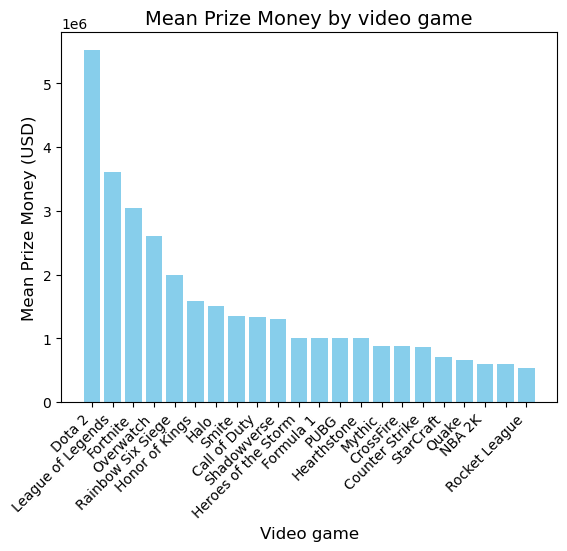

In [22]:
plt.bar(grouped_data['video_game'], grouped_data['MeanUSDPrize'], color='skyblue')
plt.xlabel('Video game', fontsize=12)
plt.ylabel('Mean Prize Money (USD)', fontsize=12)
plt.title('Mean Prize Money by video game', fontsize=14)
plt.xticks(rotation=45, ha='right');

Let's create a sub-dataset with the $5$ games with the highest mean prize moneys and only $5$ tournaments maximum for these games. This make our analysis more feasible for this milestone, and acts as a **Proof of Concept**.

In [27]:
top_games = grouped_data.head(5)
df_esports_top = df_esports[df_esports['video_game'].isin(top_games['video_game'])].groupby('video_game').head(5).reset_index(drop=True)
df_esports_top.head(20)

,TournamentName,StartDate,EndDate,Country,TeamPlay,TotalUSDPrize,Duration,video_game,TournamentDate
0,The International 2019,2019-08-15,2019-08-25,China,1,34330069,10,Dota 2,2019-08-20
1,The International 2018,2018-08-15,2018-08-25,Canada,1,25532177,10,Dota 2,2018-08-20
2,The International 2017,2017-08-02,2017-08-12,United States,1,24687919,10,Dota 2,2017-08-07
3,The International 2016,2016-08-03,2016-08-13,United States,1,20770460,10,Dota 2,2016-08-08
4,The International 2015,2015-08-03,2015-08-08,United States,1,18429613,5,Dota 2,2015-08-05
5,Fortnite World Cup Finals 2019 - Solo,2019-07-28,2019-07-28,United States,0,15287500,0,Fortnite,2019-07-28
6,Fortnite World Cup Finals 2019 - Duo,2019-07-27,2019-07-27,United States,1,15100000,0,Fortnite,2019-07-27
7,LoL 2018 World Championship,2018-10-01,2018-11-03,South Korea,1,6450000,33,League of Legends,2018-10-17
8,LoL 2016 World Championship,2016-09-29,2016-10-29,United States,1,5070000,30,League of Legends,2016-10-14
9,LoL 2017 World Championship,2017-09-23,2017-11-04,China,1,4946969,42,League of Legends,2017-10-14


### Useful functions


We define below various functions that will be useful in our analysis.

In [30]:
def timeseries_per_game(
    game_name: str, game_df: pd.DataFrame, timeseries_df: pl.DataFrame = timeseries_df
) -> pd.DataFrame:
    """
    Return a data frame with only the channels of a specific game from the timeseries data.

    Args:
        game_name: str - name of the game
        game_df: pd.DataFrame - dataframe with the channels and their respective games
        timeseries_df: pl.DataFrame - the dataframe with the timeseries data

    Returns:
        pl.DataFrame - the dataframe with the channels of the specific game present in the timeseries data
    """

    game_df = game_df[game_df["video_game"].str.contains(game_name, case=False, na=False) ]
    game_df = game_df.drop_duplicates(subset="channel_id")
    return timeseries_df.filter(
        pl.col("channel_id").is_in(game_df["channel_id"])
    )

In [ ]:
def cluster_per_subs(timeseries_df: pd.DataFrame) -> pd.DataFrame:
    """
    Assign a cluster number to each channel based on the number of subscribers.
    
    Parameters:
    timeseries_df: pd.DataFrame - the dataframe with the subscribers of all channels
    
    Returns:
    df_cluster: pd.DataFrame - the dataframe with the cluster number for each channel
    
    We keep the last 'subs' value for each 'channel_id' 
    (and not the first, in case the channel would experience major growth) 
    and assign a cluster from 1 to 5 based on this value.
    """
    
    df_cluster = timeseries_df.copy()
    df_cluster['Cluster'] = 0

    df_last_subs = df_cluster.drop_duplicates(subset='channel_id', keep='last')[['channel_id', 'subs']]
    df_cluster = df_cluster.merge(df_last_subs, on='channel_id', suffixes=('', '_last'))

    df_cluster.loc[df_cluster['subs_last'] < 20000, 'Cluster'] = 1
    
    df_cluster.loc[(df_cluster['subs_last'] >= 20000) 
                   & (df_cluster['subs_last'] < 50000), 'Cluster'] = 2
    
    df_cluster.loc[(df_cluster['subs_last'] >= 50000) 
                   & (df_cluster['subs_last'] < 200000), 'Cluster'] = 3
    
    df_cluster.loc[(df_cluster['subs_last'] >= 200000) 
                   & (df_cluster['subs_last'] < 800000), 'Cluster'] = 4
    
    df_cluster.loc[df_cluster['subs_last'] >= 800000, 'Cluster'] = 5

    df_cluster = df_cluster.drop(columns='subs_last')

    return df_cluster

In [ ]:
def cluster_per_views(timeseries_df: pd.DataFrame) -> pd.DataFrame:
    """
    Assign a cluster to each channel based on the last 'views' value.

    Parameters:
    timeseries_df: pd.DataFrame - the dataframe with the views of all channels

    Returns:
    df_cluster: pd.DataFrame - the dataframe with the assigned clusters

    We keep the last 'views' value for each 'channel_id'
    (and not the first, in case the channel would experience major growth)
    and assign a cluster from 1 to 5 based on this value.
    """

    df_cluster = timeseries_df.copy()
    df_cluster["Cluster"] = 0

    df_last_views = df_cluster.drop_duplicates(subset="channel_id", keep="last")[["channel_id", "views"]]
    df_cluster = df_cluster.merge(df_last_views, on="channel_id", suffixes=("", "_last")    )

    df_cluster.loc[df_cluster["views_last"] < 200000, "Cluster"] = 1

    df_cluster.loc[(df_cluster["views_last"] >= 200000) 
                   & (df_cluster["views_last"] < 1000000),"Cluster",] = 2

    df_cluster.loc[(df_cluster["views_last"] >= 1000000) 
                   & (df_cluster["views_last"] < 6000000),"Cluster",] = 3

    df_cluster.loc[(df_cluster["views_last"] >= 6000000) 
                   & (df_cluster["views_last"] < 100000000),"Cluster",] = 4

    df_cluster.loc[df_cluster["views_last"] >= 100000000, "Cluster"] = 5

    df_cluster = df_cluster.drop(columns="views_last")

    return df_cluster

In [ ]:
def sum_per_date(df: pd.DataFrame, metrics: str='delta_views') -> pd.DataFrame:
    """
    Calculate sum of views or subs of all channels for the same date.

    Parameters:
    df: pd.DataFrame - the dataframe with the views of all channels

    Returns:
    df_sum: pd.DataFrame - the dataframe with the sum for each date
    """

    df_sum = df[["datetime", metrics]].copy()
    df_sum["datetime"] = pd.to_datetime(df_sum["datetime"])
    df_sum["datetime"] = df_sum["datetime"].dt.floor("D")

    df_sum = df_sum.dropna(subset=["datetime", metrics])
    df_sum[metrics] = df_sum[metrics].round().astype("int64")

    df_sum = (df_sum.groupby("datetime")[metrics].sum().reset_index())
    return df_sum

In [ ]:
def mean_per_date(df: pd.DataFrame, metrics: str='delta_views') -> pd.DataFrame:
    """
    Calculate mean of views or subs of all channels for the same date.

    Parameters:
    df: pd.DataFrame - the dataframe with the views of all channels

    Returns:
    df_mean: pd.DataFrame - the dataframe with the mean for each date
    """

    df_mean = df[["datetime", metrics]].copy()
    df_mean["datetime"] = pd.to_datetime(df_mean["datetime"])
    df_mean["datetime"] = df_mean["datetime"].dt.floor("D")

    df_mean = df_mean.dropna(subset=["datetime", metrics])
    df_mean[metrics] = df_mean[metrics].round().astype("int64")

    df_mean = (df_mean.groupby("datetime")[metrics].mean().reset_index())
    return df_mean

In [ ]:
def get_tournament_dates(df_esports: pd.DataFrame, game_name: str) -> pd.Series:
    """
    Return the dates of the tournaments for a specific game.

    Parameters:
    df_esports: pd.DataFrame - the dataframe with the esports tournaments
    game_name: str - the name of the game

    Returns:
    tournament_dates: pd.Series - the dates of the tournaments for the specific game
    """

    game_df = df_esports[df_esports["video_game"] == game_name]
    tournament_dates = game_df["TournamentDate"]

    return tournament_dates

In [ ]:
def plot_clusters(
    timeseries_df: pd.DataFrame,
    df_esports: pd.DataFrame,
    game_name: str,
    window_size: int = 6,
    stats_per_date: callable = sum_per_date,
    metrics: str = 'delta_views',
) -> None:
    """
    Plot the weekly statistics for the channels of a specific game, clustered by the number of views or subscribers (mean or sum).

    Parameters:
    timeseries_df: pd.DataFrame - the dataframe with the timeseries data
    df_esports: pd.DataFrame - the dataframe with the esports tournaments
    game_name: str - the name of the game
    window_size: int - the size of the window for the rolling average
    stats_per_date: callable - the function to apply to the timeseries data per date
    *args: any - additional arguments for the stats_per_date function
    """

    num_clusters = len(timeseries_df["Cluster"].unique())
    fig, axs = plt.subplots(num_clusters, 1, figsize=(15, 4 * num_clusters))

    tournament_dates = get_tournament_dates(df_esports, game_name)

    for cluster_num in range(1, num_clusters + 1):
        cluster_df = timeseries_df[timeseries_df["Cluster"] == cluster_num]
        cluster_df = stats_per_date(cluster_df, metrics=metrics)

        cluster_df.set_index("datetime", inplace=True)

        # Weekly frequency to get better plotting results
        df_weekly = cluster_df.resample("W").mean()

        df_weekly["rolling_average"] = (
            df_weekly[stats_per_date(timeseries_df, metrics=metrics).columns[1]]
            .rolling(window=window_size)
            .mean()
        )

        axs[cluster_num - 1].plot(
            df_weekly.index, df_weekly["rolling_average"], marker="o"
        )

        # Plot a green vertical line for each tournament associated to the game
        for date in tournament_dates:
            axs[cluster_num - 1].axvline(
                x=date, color="green", linestyle="--", linewidth=1
            )

        axs[cluster_num - 1].set_title(
            f'Weekly {stats_per_date.__name__.replace("_per_date", "")} of {stats_per_date(timeseries_df, metrics=metrics).columns[1]} for {game_name} Channels (Cluster {cluster_num})'
        )
        axs[cluster_num - 1].grid(True)

        axs[cluster_num - 1].set_xlabel("Date")
        axs[cluster_num - 1].set_ylabel(stats_per_date(timeseries_df, metrics=metrics).columns[1])
    plt.tight_layout()
    plt.show()

In [ ]:
def mean_delta_views_changes_per_clusters(
    game_df: pd.DataFrame,
    df_esports: pd.DataFrame,
    days: int=30,
    cluster_type: callable = cluster_per_subs,
) -> pd.DataFrame:
    """
    Compute the mean delta views before and after tournaments for each cluster of channels.

    Parameters:
    game_df: pd.DataFrame - the dataframe with the timeseries data for a specific game
    df_esports: pd.DataFrame - the dataframe with the esports tournaments
    days: int - the number of days before and after the tournament to consider
    cluster_type: callable - the function to assign clusters to channels based on views or subscribers

    Returns:
    df_differences: pd.DataFrame - the dataframe with the mean delta views before and after tournaments
    """
    
    differences = []
    unique_games = df_esports["video_game"].unique()

    for game in unique_games:

        timeseries_game = timeseries_per_game(game_df, game)
        timeseries_game = cluster_per_subs(timeseries_game)

        tournament_dates = df_esports[df_esports["video_game"] == game]["TournamentDate"]

        for date in tournament_dates:
            date = pd.to_datetime(date)
            change = {"video_game": game, "TournamentDate": date}

            for cluster in sorted(timeseries_game["Cluster"].unique()):
                cluster_data = timeseries_game[timeseries_game["Cluster"] == cluster]

                before_tournament = (
                    cluster_data["datetime"] >= date - pd.Timedelta(days=days)
                ) & (cluster_data["datetime"] < date)
                mean_delta_views_before = cluster_data.loc[
                    before_tournament, "delta_views"
                ].mean()

                after_tournament = (cluster_data["datetime"] > date) & (
                    cluster_data["datetime"] <= date + pd.Timedelta(days=days)
                )
                mean_delta_views_after = cluster_data.loc[
                    after_tournament, "delta_views"
                ].mean()

                if mean_delta_views_before:
                    change_percent = (
                        (mean_delta_views_after - mean_delta_views_before)
                        / abs(mean_delta_views_before)
                    ) * 100
                else:
                    # Null value when no data or division by zero
                    change_percent = None

                change[f"Change_Cluster{cluster} (%)"] = np.round(change_percent, 2)

            differences.append(change)

    df_differences = pd.DataFrame(differences)
    return df_differences

In [ ]:
timeseries_dota = timeseries_per_game(games_df, 'Dota 2')

In [ ]:
cluster_dota = cluster_per_subs(timeseries_dota)

In [ ]:
cluster_dota.drop_duplicates(subset='channel_id')['Cluster'].value_counts()

We can observe how the channels are distributed across the five clusters. The clustering appears effective. As it varies for each game, it is expected to not have a 20% distribution across clusters. Instead, we may see more variation, particularly in the middle clusters (2 to 4). Additionally, the number of channels shown is limited as we are currently presenting only a sample. A more comprehensive analysis will be conducted for PM3, using more material.

In [ ]:
get_tournament_dates(df_esports_top, 'Dota 2')

We observe that the highest-paid tournament for Dota 2 occurs around the same period each year. In our full analysis, it could be interesting to investigate whether this event drives higher engagement or, conversely, stabilizes the trends.

In [ ]:
plot_clusters(cluster_dota, df_esports_top, 'Dota 2')

In [ ]:
df_changes = mean_delta_views_changes_per_clusters(game_df, df_esports, 30)

In [ ]:
df_changes.head(10)

In [ ]:
df_changes = df_changes.dropna(subset=['Change_Cluster1 (%)', 
                                                      'Change_Cluster2 (%)', 
                                                      'Change_Cluster3 (%)', 
                                                      'Change_Cluster4 (%)', 
                                                      'Change_Cluster5 (%)'], how='all')
df_changes.isnull().sum()

We drop rows only when all values are null, which likely indicates that there is no time series data available for the tournament date. However, we retain the row if there is at least one non-null value, as this suggests the presence of some time series data, even if there may not be enough data to observe changes across all clusters.

In [ ]:
positive_changes = (df[['Change_Cluster1 (%)', 
                        'Change_Cluster2 (%)', 
                        'Change_Cluster3 (%)', 
                        'Change_Cluster4 (%)', 
                        'Change_Cluster5 (%)']]>0).all(axis=1).sum()
positive_changes

In more than 10% of the rows, the mean of delta_views during the month following a tournament is greater than the month before. Even if this number is not huge, it is still important. Indeed, considering the huge number big video games' followers, this represents an important increase in views in Youtube statistics. Moreover, as already said, it is only a sample so we will likely discover more interesting insights in our final analysis in PM3 and try to uncover patterns.

## Communities on YouTube

We now want to extract community insights using the **comments** part of the dataset. More precisely, we want to link viewers that have commented on **plenty channels**, to see if some patterns emerge.

Due to the fact that we have a tremendous amount of data to process, and since we only focus on **Gaming** videos, we start by filtering the dataset to only keep the Gaming comments.

In [ ]:
import polars as pl

In [ ]:
channels_df = pl.read_csv(CHANNELS_PATH, separator="\t")
videos_df = pl.read_ndjson(VIDEOS_PATH)

channels_df.head()

Our goal is to join the data contained in the Channel Data (containing the mapping from the `channel_id` to the `channel_name`), the Video Metadata (containing the mapping from the `video_id` to the `channel_id`), and the Comments (containing the mapping from the `video_id` to the `author`).
By doing so we will have the mapping from the `author` to the `channel_name` which will allow us to see the ones that have commented on multiple channels, and observe what are the **most common links** between channels, to identify potential **communities** and clusters.

Firstly, we join our Channel Data with the Video Metadata, and keep only the needed columns (`display_id` to map to the comments' authors, `channel` to adress channels by their name instead of ID's, and `subscribers` to represent bigger channels with bigger points on the graphs).

In [ ]:
joined_df = videos_df.join(channels_df, left_on="channel_id", right_on="channel")

joined_df = joined_df.select(
    [
        pl.col("display_id"),
        pl.col("channel_id"),
        pl.col("name_cc"),
        pl.col("subscribers_cc"),
    ]
).rename({"name_cc": "channel", "subscribers_cc": "subscribers"})

joined_df.unique("channel").sort("subscribers").reverse().head(10)

It is now time to proceed on comments. For **PM2**, we just took a 100M subset of the comments for the sake of performance.

In [ ]:
comments_df = pl.scan_csv(COMMENTS_PATH, separator="\t", has_header=True)

We now join the previously joined_data with the comments (`display_id` to `video_id`), and we suppress the number of likes and replies since they are not needed for our analysis.

In [ ]:
comments_video_channels = comments_df.join(
    joined_df.lazy(), left_on="video_id", right_on="display_id"
)

comments_channels = comments_video_channels.select(
    [pl.col("author"), pl.col("channel")]
).unique()

comments_channels.head().collect()

For our graph, the users that commented on only one channel are **not relevant** for our analysis, because they don't illustrate any sort of connection between channels communities. We thus filter them out.

In [ ]:
counts_per_author = (
    comments_channels.group_by("author")
    .agg(pl.col("channel").count().alias("count"))
    .filter(pl.col("count") > 1)
)

# We remove the authors that commented on only one channel
comments_several_channels = comments_channels.join(
    counts_per_author, on="author", how="inner"
).select(["author", "channel"])

Our final graph input needs to be of the form `source, target, weight`, where `source` and `target` are the channel names, and `weight` is the number of users that commented on both channels. We then aggregate the data to have the final graph.

Note that we **alphabetically sorted** the two channels that are linked by the edge, to avoid duplicates (i.e. if an author made comments under channels A, B and C, we would add 3 edges A-B, A-C and B-C but not the B-A, C-A and C-B ones).

In [ ]:
pairs = (
    comments_several_channels.join(comments_several_channels, on="author", how="inner")
    .filter(pl.col("channel") < pl.col("channel_right"))
    .select(["channel", "channel_right"])
)

pairs_grouped = pairs.group_by(["channel", "channel_right"]).agg(
    pl.col("channel").count().alias("weight")
)

pairs_grouped.collect()

As the generation for 100M comments took a lot of time, we decided to **save** the final graph in a `.csv` file to avoid reprocessing the data.

To improve the meaning of our edges that connects two channels, we decided to **keep only** the edges that have a weight of **at least 1000**. This way, we can focus on the **most relevant** connections between channels.

In [ ]:
pairs_grouped_filtered = (
    pl.scan_csv("edges.csv")
    .filter(pl.col("weight") > 1000)
    .sort("weight", descending=True)
)

edges = pairs_grouped_filtered.collect()

edges.head()

Now that we have all the edges we want, we can get all the **nodes** (channes) from the edges and before plotting the graph, we first get back the **subscribers** count for each channel to represent them with bigger points on the graph.

In [ ]:
channels_filtered = edges.select(["channel"]).unique()

nodes = (
    channels_filtered.join(
        channels_df, left_on="channel", right_on="name_cc", how="inner"
    )
    .select(["channel", "subscribers_cc"])
    .sort("subscribers_cc", descending=True)
)

nodes.head()

For the final graph, we used the `networkx` library to plot the graph, and we used the `kamada_kawai_layount`, which separates well the clusters to have a better visualization of the communities. The `best_partition` function from the `community` module allows us to identify the communities in the graph.

More precisely, each node represents a **channel** (the size of the node is proportional to the number of subscribers of the channel), and each edge represents a **connection between two channels** (when the weight of the edge is at least 1000).

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community

G = nx.Graph()

for row in nodes.iter_rows(named=True):
    G.add_node(row["channel"], subscribers=row["subscribers_cc"])

for row in edges.iter_rows(named=True):
    G.add_edge(row["channel"], row["channel_right"], weight=row["weight"])

In [ ]:
partition = community.best_partition(G, weight="weight")
pos = nx.kamada_kawai_layout(G, weight="weight")

Below are defined the **parameters** of the graph, such as **colors and sizes** of different nodes. We defined communities' colors **manually** to have a better visualization of the graph.

We also showed on the graph the names of channels that have more than **10M subscribers**, to see where the most famous YouTubers are located in the graph.

In [ ]:
clusters = set(partition.values())
colors = [
    "#39C5DB",
    "#1AA5E0",
    "#FF5450",
    "#FEBA33",
    "#E08300",
    "#4FC43D",
    "#8A52F5",
    "#3BCEAC",
    "#F4D35E",
    "#EE964B",
    "#8BC34B",
]

color_map = dict(zip(clusters, colors))

default_color = "#D3D3D3"

node_colors = [
    color_map.get(partition[node], default_color)
    for node in G.nodes
    if node in partition
]

edge_colors = [
    color_map.get(partition[edge[0]], default_color)
    for edge in G.edges
    if edge[0] in partition
]

node_sizes = [G.nodes[node].get('subscribers') for node in G.nodes()]
node_sizes = [max(size / 100000, 10) if size else 10 for size in node_sizes]

label_threshold = 10000000
labels = {node: node if G.nodes[node].get('subscribers') and (G.nodes[node].get('subscribers') > label_threshold) else '' for node in G.nodes()}

Last step is to show the graph and observe it the **communities connections** that emerged from the data!

In [ ]:
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.1,
)

nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=16,
    verticalalignment="bottom",
    horizontalalignment="right",
)

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.1)

plt.gcf().set_size_inches(40, 30)
plt.show()